# STEP # 1 - DATA PREPARATION. 
## Our goal is to predict patient diagnoses, procedures, services and Rx. In this notebook, we only read claims data and prepare the data suitable for training. In further notebooks, we train models and perform predictions.

In [1]:
import os
import pandas as pd
import numpy as np
from ConstantsNamespace import PatientJourneyConstantsNamespace
from sklearn.metrics.pairwise import cosine_similarity

### Constants for file names

In [2]:
constants = PatientJourneyConstantsNamespace()

### Read month-wise member consumption data (features) for 2021 and 2022 
### i.e. Medical and Behavioral Diagnoses, Medical and Behavioral Serviecs, Procedures, RX
#### The features here are only the top-most level of the diagnosis hierarchy, procedure hierarchy, rx hierarchy, service hierarchy. 

In [3]:
diagbh2021_df = pd.read_csv(constants.DIAGBH2021_FILEPATH, sep='\t', header=0)
diagmd2021_df = pd.read_csv(constants.DIAGMD2021_FILEPATH, sep='\t', header=0)
procmd2021_df = pd.read_csv(constants.PROCMD2021_FILEPATH, sep='\t', header=0)
rx2021_df     = pd.read_csv(constants.RX2021_FILEPATH, sep='\t', header=0)
servbh2021_df = pd.read_csv(constants.SERVBH2021_FILEPATH, sep='\t', header=0)
servmd2021_df = pd.read_csv(constants.SERVMD2021_FILEPATH, sep='\t', header=0)
diagbh2022_df = pd.read_csv(constants.DIAGBH2022_FILEPATH, sep='\t', header=0)
diagmd2022_df = pd.read_csv(constants.DIAGMD2022_FILEPATH, sep='\t', header=0)
procmd2022_df = pd.read_csv(constants.PROCMD2022_FILEPATH, sep='\t', header=0)
rx2022_df     = pd.read_csv(constants.RX2022_FILEPATH, sep='\t', header=0)
servbh2022_df = pd.read_csv(constants.SERVBH2022_FILEPATH, sep='\t', header=0)
servmd2022_df = pd.read_csv(constants.SERVMD2022_FILEPATH, sep='\t', header=0)

all_data_dfs_list = [diagbh2021_df, diagmd2021_df, procmd2021_df, rx2021_df, servbh2021_df, servmd2021_df, diagbh2022_df, diagmd2022_df, procmd2022_df, rx2022_df, servbh2022_df, servmd2022_df]
all_data_dfs = pd.concat(all_data_dfs_list)

In [4]:
all_data_dfs.head(4)

,memid,dimMonthID,featureid
0,1794474,20210301,d19
1,88972,20210401,d19
2,1654929,20211201,d19
3,414065,20211001,d19


### Create consecutive integer member ids for easy computation

In [5]:
unique_memids = np.sort(np.array(all_data_dfs['memid'].unique()))
memid_id = np.arange(len(unique_memids))
unique_memids = pd.DataFrame(zip(unique_memids, memid_id))
unique_memids.columns = ['memid', 'memid_id']

all_data_dfs = all_data_dfs.merge(unique_memids, how='inner')

In [6]:
all_data_dfs.head(2)

,memid,dimMonthID,featureid,memid_id
0,1794474,20210301,d19,12786
1,1794474,20210401,d19,12786


### Read meta-data of consumed features

In [7]:
dummy_ids_diag = pd.read_csv(constants.DUMMY_IDS_DIAG_FILEPATH, sep='\t', header=0)
dummy_ids_proc = pd.read_csv(constants.DUMMY_IDS_PROC_FILEPATH, sep='\t', header=0)
dummy_ids_rx = pd.read_csv(constants.DUMMY_IDS_RX_FILEPATH, sep='\t', header=0)
dummy_ids_serv = pd.read_csv(constants.DUMMY_IDS_SERV_FILEPATH, sep='\t', header=0)

all_dummy_ids_list = [dummy_ids_diag, dummy_ids_proc, dummy_ids_rx, dummy_ids_serv]
dummy_ids_df = pd.concat(all_dummy_ids_list)

In [8]:
dummy_ids_df.head(4)

,level1dummyid,featureid,featuretype,Level1
0,1,d1,diag,Certain conditions originating in the perinata...
1,2,d2,diag,Certain infectious and parasitic diseases (A00...
2,3,d3,diag,Codes for special purposes (U00-U85)
3,4,d4,diag,"Congenital malformations, deformations and chr..."


### Create consecutive integer feature ids for easy computation

In [9]:
all_data_dfs = all_data_dfs.merge(dummy_ids_df, how='inner')
unique_featureids = np.array(all_data_dfs.sort_values(by=['featuretype', 'level1dummyid'])['featureid'].unique())
featureid_id = np.arange(len(unique_featureids))
unique_featureids = pd.DataFrame(zip(unique_featureids, featureid_id))
unique_featureids.columns = ['featureid', 'featureid_id']
all_data_dfs = all_data_dfs.merge(unique_featureids, how='inner')

In [10]:
all_data_dfs.head(2)

,memid,dimMonthID,featureid,memid_id,level1dummyid,featuretype,Level1,featureid_id
0,1794474,20210301,d19,12786,19,diag,"Mental, Behavioral and Neurodevelopmental diso...",18
1,1794474,20210401,d19,12786,19,diag,"Mental, Behavioral and Neurodevelopmental diso...",18


### Create a dataframe for metadata on feature ids, types and their descriptions

In [11]:
unique_featureids_and_desc = all_data_dfs[['featureid_id', 'featuretype', 'Level1']].drop_duplicates().sort_values(by=['featureid_id'])

In [12]:
unique_featureids_and_desc.head(2)

,featureid_id,featuretype,Level1
2407398,0,diag,Certain conditions originating in the perinata...
470036,1,diag,Certain infectious and parasitic diseases (A00...


# SIMILARITY BETWEEN FEATURES
## We see if there are features which are similar to each other based on members who consume them.
## After vectorizing the members consuming features, we find cosine similarity between each feature.

### Create list of members which consume each feature respectively  

In [13]:
feature_to_memlist_df = pd.DataFrame(all_data_dfs.groupby(['featureid_id'])['memid_id'].apply(lambda x: list(np.unique(x))))
feature_to_memlist_df.reset_index(inplace=True)

In [14]:
feature_to_memlist_df.head(2)

,featureid_id,memid_id
0,0,"[130, 259, 371, 1005, 1250, 2489, 2800, 2981, ..."
1,1,"[1, 4, 5, 7, 8, 10, 11, 13, 17, 21, 22, 23, 24..."


### Vectorize the list of members. We essentially one-hot-encode the vector.

In [15]:
results = np.zeros((len(unique_featureids), len(unique_memids)))
for index, row in feature_to_memlist_df.iterrows():
    results[index, row['memid_id']] = 1

In [16]:
results.shape

(160, 15937)

In [17]:
results

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Find cosine similarity

In [18]:
cosine_sim_scores = cosine_similarity(results)

In [19]:
cosine_sim_scores.shape

(160, 160)

In [20]:
cosine_sim_scores

array([[1.        , 0.05925926, 0.04319967, ..., 0.01447402, 0.01968748,
        0.        ],
       [0.05925926, 1.        , 0.3304396 , ..., 0.16886355, 0.05249995,
        0.02093707],
       [0.04319967, 0.3304396 , 1.        , ..., 0.12834548, 0.04565803,
        0.01101691],
       ...,
       [0.01447402, 0.16886355, 0.12834548, ..., 1.        , 0.03419483,
        0.00779255],
       [0.01968748, 0.05249995, 0.04565803, ..., 0.03419483, 1.        ,
        0.        ],
       [0.        , 0.02093707, 0.01101691, ..., 0.00779255, 0.        ,
        1.        ]])

### Visualize similarities :-
#### In the plot below, we see that -
#### * The diagonal is the brightest because each item (feature) is always similar to itself.
#### * There are some bright areas at the corners, where some diagnoses and some services are similar to other diagnoses and some services.
#### * There are some less bright areas in the internal regions, where there are similarities between rx and procedures.
### We may research more (with more data on features) to see if better similarities can be computed to reduce the feature space. 

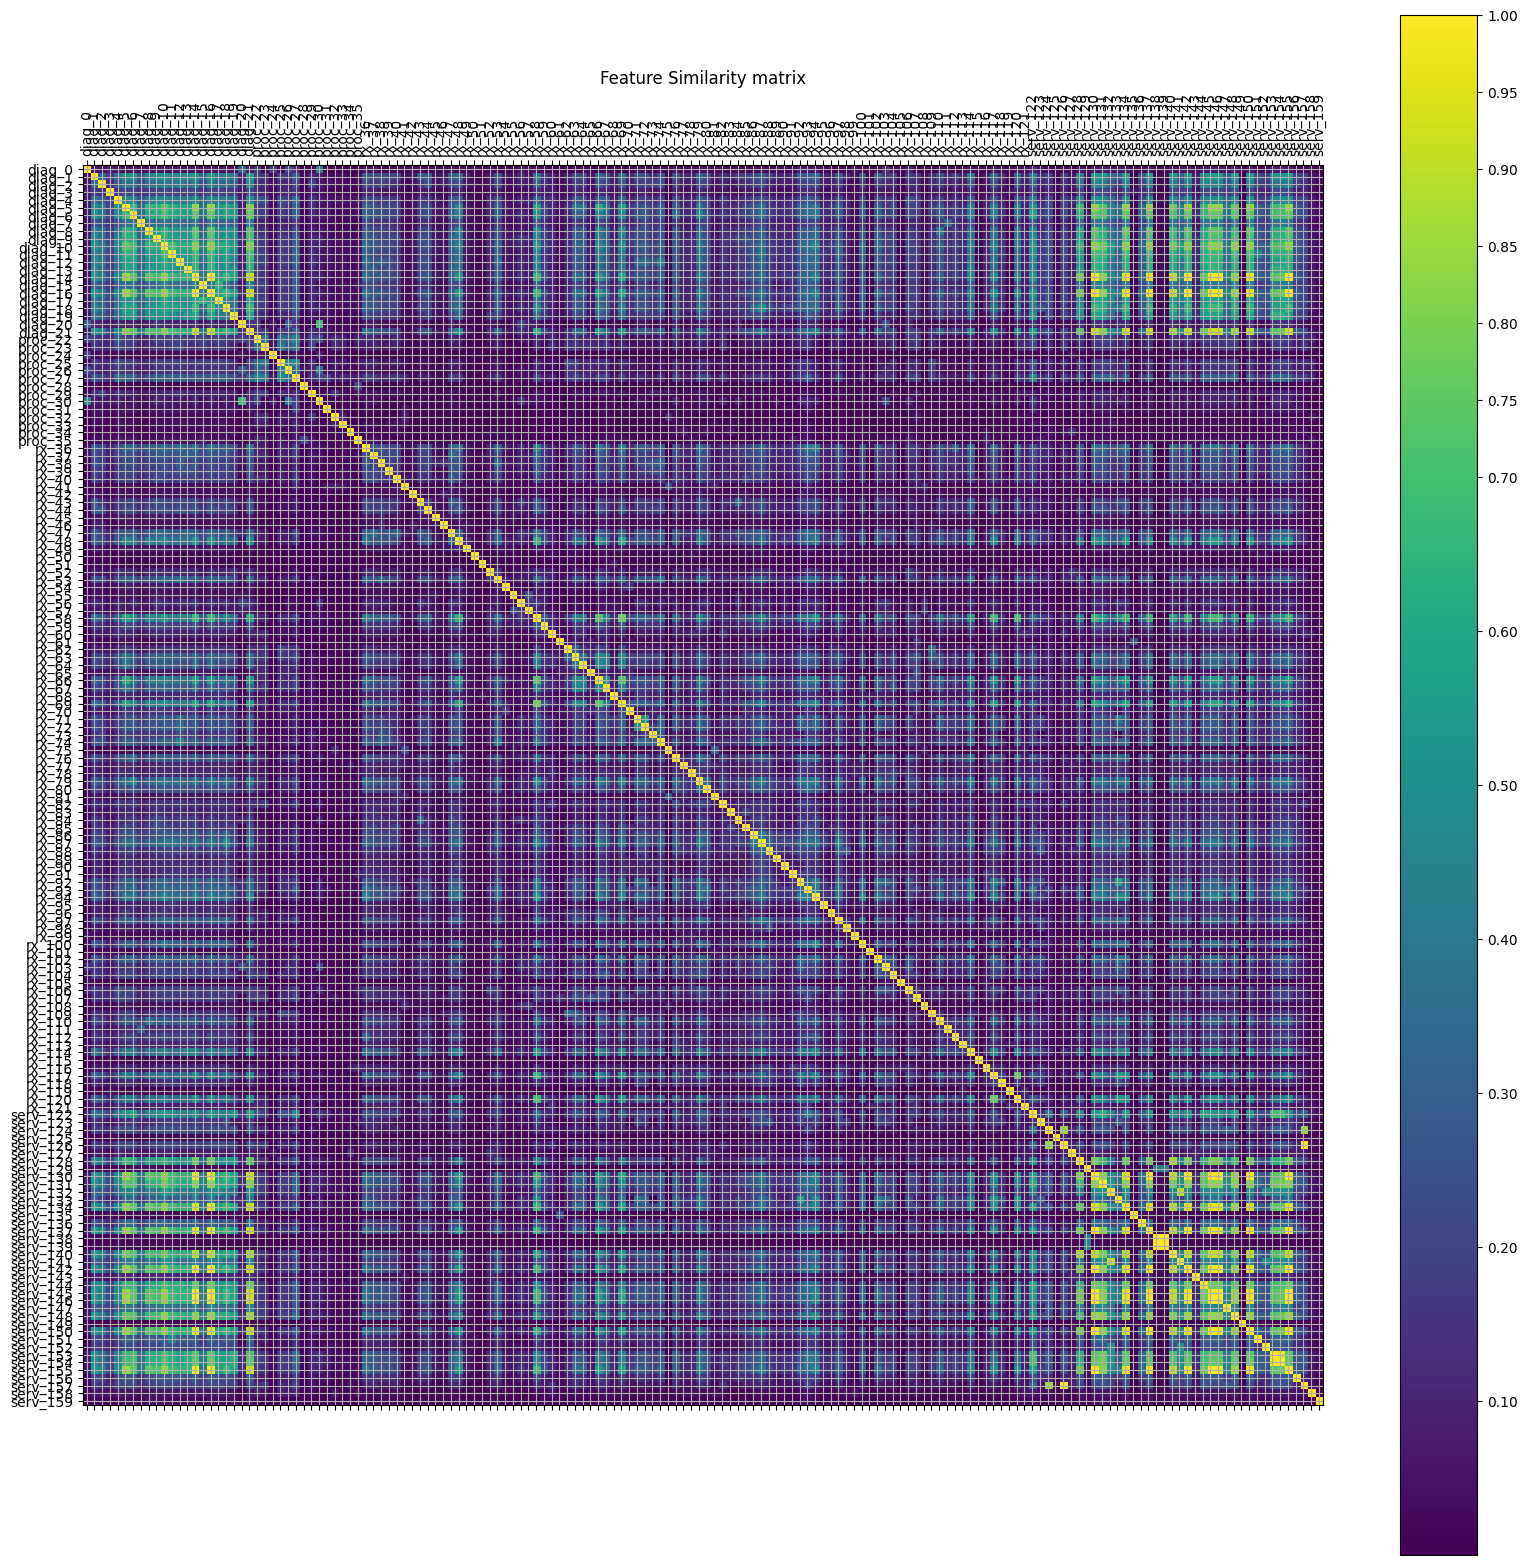

In [21]:
import matplotlib.pyplot as plt
 
labels = list(unique_featureids_and_desc['featuretype'] + '_' + unique_featureids_and_desc['featureid_id'].astype(str))
 
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(cosine_sim_scores, interpolation='nearest')
ax.grid(True)
plt.title('Feature Similarity matrix')
plt.xticks(range(160), labels, rotation=90);
plt.yticks(range(160), labels);
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

# DATA PREPARATION FOR PREDICTIONS :-
### We start preparing data so as to feed it to a neural network.

### DATA :-
### * One instance of input data is binary (0 or 1) data on 160 features consumed in a month. This will be achieved by one-hot-encoding the feature consumption instance of each month. 
### * Before doing so, we carry forward (bubble down) the history that a member consumes over time. This means, if a member has a feature consumed in a particular month, then that feature input will be 1 for all further months. This is because, generally we know that if a member consumes say, an rx or gets a diagnosis, then the member is very likely to get that rx or that diagnosis in future, OR this rx or diagnosis is going to affect further medical journey of that member.  

### DATA LABELS OR TARGETS (WHAT WE PREDICT) :-
### * Each month, if there is any consumption by a member, it could be a repeated feature from the past - ex: as part a regular RX schedule or the same diagnosis coming up in a claim at another doctor's office.
### * We build a model to predict new instances of whether a member will start consuming BETA BLOCKERS in future. This particular rx consumption is useful to know about, because it is related to high blood pressure and various heart ailments which can be expensive to treat.

### Create list of unique features consumed per member per month and create a dense rank for month 

In [22]:
mem_to_featurelist_df = pd.DataFrame(all_data_dfs.groupby(['memid_id', 'dimMonthID'])['featureid_id'].apply(lambda x: list(np.unique(x))))
mem_to_featurelist_df.reset_index(inplace=True)
mem_to_featurelist_df['memid_month_rank'] = mem_to_featurelist_df.groupby(['memid_id'])['dimMonthID'].rank('dense')
mem_to_featurelist_df = mem_to_featurelist_df.sort_values(by=['memid_id', 'memid_month_rank'])

In [23]:
mem_to_featurelist_df.shape

(239676, 4)

In [24]:
mem_to_featurelist_df.head(2)

,memid_id,dimMonthID,featureid_id,memid_month_rank
0,0,20210101,[104],1.0
1,0,20210301,"[63, 67, 69, 79]",2.0


### CARRY FORWARD FEATURES CONSUMED BY MEMBERS

#### Create list of all features grouped by memid 

In [25]:
memid_to_list = pd.DataFrame(mem_to_featurelist_df.groupby(['memid_id']).agg(list))
memid_to_list.reset_index(inplace=True)

#### We only want consumption data for more than a month. This is because, just a month of consumption cannot be used to train 

In [26]:
memid_to_list['cnt_of_months_of_data'] = memid_to_list.apply(lambda x: len(x.loc['memid_month_rank']), axis=1)

In [27]:
memid_to_list = memid_to_list[memid_to_list['cnt_of_months_of_data']>1]

In [28]:
memid_to_list.shape

(15790, 5)

In [29]:
memid_to_list.head(2)

,memid_id,dimMonthID,featureid_id,memid_month_rank,cnt_of_months_of_data
0,0,"[20210101, 20210301, 20210401, 20210501, 20210...","[[104], [63, 67, 69, 79], [5, 12, 14, 16, 19, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",23
1,1,"[20210101, 20210201, 20210301, 20210401, 20210...","[[11, 16, 18, 43, 44, 58, 69, 79, 86, 87, 88, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",24


#### Loop through and carry forward (bubble down) the feature consumption

In [30]:
mem_list = []
rnk_list = []
ftr_list = []
for i in range(len(memid_to_list)):
    m = memid_to_list.iloc[i]['memid_id']
    list_of_ranks = memid_to_list.iloc[i]['memid_month_rank']
    list_of_featurelists = memid_to_list.iloc[i]['featureid_id']
    len_of_list = len(list_of_featurelists)

    rnk_ctr = 0   # This variable is used outside the loop for the last rank's id
    next_feature_list = [] 
    for j in range(len_of_list - 1): # -1 because we want j and j+1 inside the loop
        rnk = list_of_ranks[j]
        rnk_ctr = rnk 

        # Update features at next rank = (features at next rank) + (features in current rank which are not in next rank)   
        list_of_featurelists[j+1] = list_of_featurelists[j+1] + list(set(list_of_featurelists[j]) - set(list_of_featurelists[j+1] )) 
        #print(m, '===', rnk, '===', len(list_of_featurelists[j]), '===', len(list_of_featurelists[j+1]), '\n')
        
        mem_list.append(m)
        rnk_list.append(rnk)
        ftr_list.append(list_of_featurelists[j])
        next_feature_list = list_of_featurelists[j+1]  # This variable is used outside the loop for the last rank's feature list

    # outside the loop, insert details of the last rank of that mem
    mem_list.append(m)
    rnk_list.append(rnk_ctr+1)
    ftr_list.append(next_feature_list)

df = pd.DataFrame({'memid_id': mem_list, 'memid_month_rank':rnk_list, 'featureid_id_bubbled_down':ftr_list})

In [31]:
df.head(5)

,memid_id,memid_month_rank,featureid_id_bubbled_down
0,0,1.0,[104]
1,0,2.0,"[63, 67, 69, 79, 104]"
2,0,3.0,"[5, 12, 14, 16, 19, 21, 68, 69, 79, 104, 128, ..."
3,0,4.0,"[16, 21, 53, 62, 67, 79, 104, 130, 137, 140, 1..."
4,0,5.0,"[12, 16, 17, 21, 58, 67, 71, 73, 130, 137, 140..."


#### Merge in order to consolidate the bubbled-down consumption

In [32]:
mem_to_featurelist_df = mem_to_featurelist_df.merge(df, on=['memid_id', 'memid_month_rank'], how='inner')

In [33]:
mem_to_featurelist_df.head(3)

,memid_id,dimMonthID,featureid_id,memid_month_rank,featureid_id_bubbled_down
0,0,20210101,[104],1.0,[104]
1,0,20210301,"[63, 67, 69, 79]",2.0,"[63, 67, 69, 79, 104]"
2,0,20210401,"[5, 12, 14, 16, 19, 21, 68, 69, 79, 104, 128, ...",3.0,"[5, 12, 14, 16, 19, 21, 68, 69, 79, 104, 128, ..."


#### Now merge with self, such that consumption of a month is on the left (this is the input) and consumption of the next month (next rank to be precise) is on the right (this is the label or target)

In [34]:
x = mem_to_featurelist_df.merge(mem_to_featurelist_df, on=['memid_id'], how='outer')
x = x[x['memid_month_rank_x']+1==x['memid_month_rank_y']]

### Separate the target into -
### (1) Repeat Features (which have already been consumed in the past too), and
### (2) New Features (which have never been consumed in the past). 

### We can build a model to predict any of the above. We choose to build the model for New Features and specifically for RX BETA BLOCKERS

In [35]:
x['repeat_features'] = x.apply(lambda z : list(
                                                set(z.loc['featureid_id_bubbled_down_x']) & 
                                                set(z.loc['featureid_id_bubbled_down_y'])
                                               ) , axis=1)

x['new_features'] = x.apply(lambda z : [
                                        item for item in z.loc['featureid_id_bubbled_down_y'] 
                                              if item not in z.loc['featureid_id_bubbled_down_x']
                                       ] , axis=1
                           )

In [36]:
x[['memid_id','memid_month_rank_x','featureid_id_bubbled_down_x','featureid_id_bubbled_down_y', 'repeat_features', 'new_features']]

,memid_id,memid_month_rank_x,featureid_id_bubbled_down_x,featureid_id_bubbled_down_y,repeat_features,new_features
1,0,1.0,[104],"[63, 67, 69, 79, 104]",[104],"[63, 67, 69, 79]"
25,0,2.0,"[63, 67, 69, 79, 104]","[5, 12, 14, 16, 19, 21, 68, 69, 79, 104, 128, ...","[67, 69, 104, 79, 63]","[5, 12, 14, 16, 19, 21, 68, 128, 130, 137, 140..."
49,0,3.0,"[5, 12, 14, 16, 19, 21, 68, 69, 79, 104, 128, ...","[16, 21, 53, 62, 67, 79, 104, 130, 137, 140, 1...","[128, 130, 5, 137, 12, 140, 14, 142, 16, 145, ...","[53, 62, 148]"
73,0,4.0,"[16, 21, 53, 62, 67, 79, 104, 130, 137, 140, 1...","[12, 16, 17, 21, 58, 67, 71, 73, 130, 137, 140...","[128, 130, 5, 137, 140, 12, 142, 14, 16, 145, ...","[17, 58, 71, 73, 144]"
97,0,5.0,"[12, 16, 17, 21, 58, 67, 71, 73, 130, 137, 140...","[67, 69, 104, 128, 130, 68, 5, 71, 79, 137, 73...","[128, 130, 5, 137, 12, 140, 142, 14, 16, 17, 1...",[]
...,...,...,...,...,...,...
4293524,15915,1.0,"[5, 14, 16, 58, 64, 66, 69, 114, 120, 130, 137...","[58, 64, 66, 69, 120, 130, 5, 137, 14, 16, 145...","[64, 66, 130, 5, 69, 137, 14, 16, 145, 114, 14...",[]
4293528,15916,1.0,[66],"[5, 11, 12, 14, 16, 130, 134, 137, 142, 145, 1...",[66],"[5, 11, 12, 14, 16, 130, 134, 137, 142, 145, 1..."
4293532,15920,1.0,"[4, 5, 9, 14, 16, 18, 21, 71, 77, 97, 117, 118...","[4, 5, 9, 10, 11, 12, 14, 16, 18, 21, 60, 71, ...","[130, 131, 4, 5, 134, 9, 14, 142, 16, 144, 18,...","[10, 11, 12, 60, 78, 86, 102, 103, 124, 133, 1..."
4293536,15924,1.0,"[12, 21, 130, 137, 142, 145, 146, 150, 155]","[5, 6, 14, 58, 66, 130, 137, 145, 146, 150, 15...","[130, 137, 12, 142, 145, 146, 21, 150, 155]","[5, 6, 14, 58, 66]"


#### One-hot-encode all input and output. This gives an input and output of 160 features each.

In [37]:
featureid_id_bubbled_down_x = np.zeros((len(x), len(unique_featureids_and_desc)))
featureid_id_bubbled_down_y = np.zeros((len(x), len(unique_featureids_and_desc)))
repeat_features = np.zeros((len(x), len(unique_featureids_and_desc)))
new_features = np.zeros((len(x), len(unique_featureids_and_desc)))
for index in range(len(x)):
    featureid_id_bubbled_down_x[index, x.iloc[index]['featureid_id_bubbled_down_x']] = 1
    featureid_id_bubbled_down_y[index, x.iloc[index]['featureid_id_bubbled_down_y']] = 1
    repeat_features[index, x.iloc[index]['repeat_features']] = 1
    new_features[index, x.iloc[index]['new_features']] = 1

#### Just to remind ourselves of the dataframe 'unique_featureids_and_desc' which has metadata of features

In [38]:
unique_featureids_and_desc.head(5)

,featureid_id,featuretype,Level1
2407398,0,diag,Certain conditions originating in the perinata...
470036,1,diag,Certain infectious and parasitic diseases (A00...
2202692,2,diag,Codes for special purposes (U00-U85)
2348758,3,diag,"Congenital malformations, deformations and chr..."
2206928,4,diag,Diseases of the blood and blood-forming organs...


#### Save the encoded data as well as 'unique_featureids_and_desc' to disk

In [39]:
np.save('step_01_output/featureid_id_bubbled_down_x.npy', featureid_id_bubbled_down_x)
np.save('step_01_output/featureid_id_bubbled_down_y.npy', featureid_id_bubbled_down_y)
np.save('step_01_output/repeat_features.npy', repeat_features)
np.save('step_01_output/new_features.npy', new_features)

unique_featureids_and_desc.to_csv('step_01_output/unique_featureids_and_desc', sep='\t', index=False)